# Project 1 – Decision Trees and Random Forests

#### Imports
Imports og random seed

In [155]:


import numpy as np
import matplotlib.pyplot as plt

from itertools import product
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from decision_tree import DecisionTree
from random_forest import RandomForest

# random seed
RANDOM_SEED = 21



### Load dataset

Laster inn letters.csv og deler opp i features (X) og labels (y), og deler inn i test/train datasett (80/20)

In [156]:
data = np.genfromtxt("letters.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[f] for f in feature_names]).T
y = data[target_name].astype(int)

# 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, shuffle=True, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")

X_train shape: (1600, 16), y_train shape: (1600,)
X_test shape: (400, 16), y_test shape: (400,)
Feature columns names: ['xbox', 'ybox', 'width', 'high', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'xege', 'xegvy', 'yege', 'yegvx']
Target column name: label


### Hyperparametere

Setter opp verdier som skal testes i grid search for DecisionTree og RandomForest.

In [157]:
dt_params = {
    "criterion": ["entropy", "gini"],
    "max_depth": [3, 5, 10, 15],
    "max_features": ["sqrt", "log2"],
}

rf_params = {
    "n_estimators": [20, 30, 40],
    "max_depth": [3, 5, 10, 15],
    "criterion": ["entropy", "gini"],
    "max_features": ["sqrt", "log2"],
}


### Cross-validation

Funksjon for k-fold cross validation som regner ut accuracy.

In [158]:
def cross_val_score(model_class, params, X, y, k=5, seed=RANDOM_SEED):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_class(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))
    return float(np.mean(scores))


### DecisionTree grid search

Tester kombinasjoner av hyperparametere og finner beste for DecisionTree.

In [159]:
results_dt = []
best_dt_params = None
best_dt_score = -1.0

for criterion, max_depth, max_features in product(
    dt_params["criterion"], dt_params["max_depth"], dt_params["max_features"]
):
    params = {
        "criterion": criterion,
        "max_depth": max_depth,
        "max_features": max_features,
    }
    score = cross_val_score(
        DecisionTree, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_dt.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_dt_score:
        best_dt_score = mean_score
        best_dt_params = params

df_dt_results = pd.DataFrame(results_dt).sort_values(by="cv_score", ascending=False)

print("Best DecisionTree params:", best_dt_params)
print("Best DecisionTree 5-fold CV accuracy:", round(best_dt_score, 4))
df_dt_results.head()


Best DecisionTree params: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt'}
Best DecisionTree 5-fold CV accuracy: 0.8725


,criterion,max_depth,max_features,cv_score
6,entropy,15,sqrt,0.872500
14,gini,15,sqrt,0.871875
12,gini,10,sqrt,0.870000
13,gini,10,log2,0.866875
5,entropy,10,log2,0.863750


### RandomForset - grid Serach
Tester kombinasjoner av hyperparametere og finner beste for RandomForest. (approx 6 min runtime)

In [160]:
results_rf = []
best_rf_params = None
best_rf_score = -1.0

for n_estimators, max_depth, criterion, max_features in product(
    rf_params["n_estimators"],
    rf_params["max_depth"],
    rf_params["criterion"],
    rf_params["max_features"],
):
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "criterion": criterion,
        "max_features": max_features,
    }
    score = cross_val_score(
        RandomForest, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_rf.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_params = params

df_rf_results = pd.DataFrame(results_rf).sort_values(by="cv_score", ascending=False)

print("Best RandomForest params:", best_rf_params)
print("Best RandomForest 5-fold CV accuracy:", round(best_rf_score, 4))
df_rf_results.head()


Best RandomForest params: {'n_estimators': 40, 'max_depth': 15, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best RandomForest 5-fold CV accuracy: 0.9669


,n_estimators,max_depth,criterion,max_features,cv_score
44,40,15,entropy,sqrt,0.966875
45,40,15,entropy,log2,0.962500
42,40,10,gini,sqrt,0.961875
31,30,15,gini,log2,0.961875
46,40,15,gini,sqrt,0.961875


## DecisionTree accuracy vs max_depth


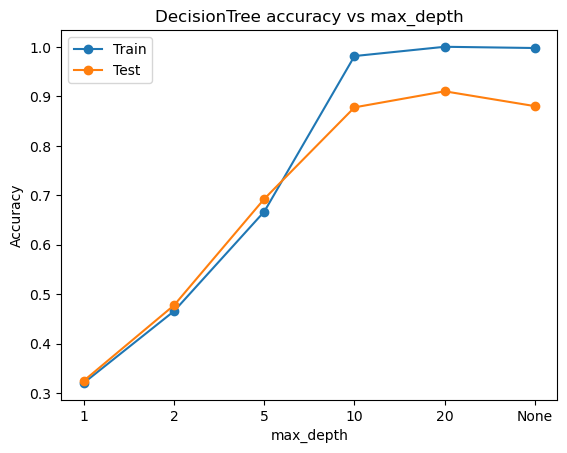

In [161]:
depths = [1, 2, 5, 10, 20, None]
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTree(max_depth=d, criterion="gini", max_features="sqrt")
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train")
plt.plot([str(d) for d in depths], test_scores, marker="o", label="Test")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("DecisionTree accuracy vs max_depth")
plt.legend()
plt.show()

## RandomForest accuracy vs n_estimator

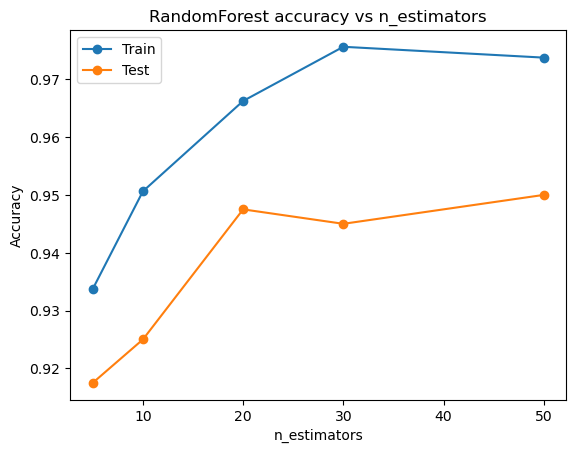

In [162]:
estimators = [5, 10, 20, 30, 50]
train_scores = []
test_scores = []

for n in estimators:
    model = RandomForest(n_estimators=n, max_depth=7, criterion="gini", max_features="sqrt")
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(estimators, train_scores, marker="o", label="Train")
plt.plot(estimators, test_scores, marker="o", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("RandomForest accuracy vs n_estimators")
plt.legend()
plt.show()

### Evaluation of grid search hyperparameters

We test the hyperparameters found by grid search on the full training set and evaluate on the test set

In [163]:
# DecisionTree
dt_best = DecisionTree(**best_dt_params)
dt_best.fit(X_train, y_train)
dt_pred = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# RandomForest
rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)
rf_pred = rf_best.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Print accuracy
print(f"DecisionTree test accuracy: {dt_acc:.4f}")
print(f"RandomForest test accuracy: {rf_acc:.4f}")


DecisionTree test accuracy: 0.8900
RandomForest test accuracy: 0.9775


### Final evaluation

Instead of using the grid search hyperparameters, we use the most correct values based on theory and our own analysis (argued in the rapport). Again, we use the full training set and evaluate on the test set.


In [169]:
dt_manual = DecisionTree(
    max_depth=7,
    criterion="gini",
    max_features="sqrt",
    random_state=RANDOM_SEED
)
dt_manual.fit(X_train, y_train)
dt_pred = dt_manual.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

rf_manual = RandomForest(
    n_estimators=30,     
    max_depth=7,           
    criterion="gini", 
    max_features="sqrt",
    random_state=RANDOM_SEED
)
rf_manual.fit(X_train, y_train)
rf_pred = rf_manual.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Print accuracy
print(f"DecisionTree test accuracy: {dt_acc:.4f}")
print(f"RandomForest test accuracy: {rf_acc:.4f}")

DecisionTree test accuracy: 0.8325
RandomForest test accuracy: 0.9250


### SKLearn modeller

Trener modell med sklearn med de samme paramterene

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sk_dt_manual = DecisionTreeClassifier(
    max_depth=5,
    criterion="gini",
    max_features="sqrt",
    random_state=RANDOM_SEED

)
sk_dt_manual.fit(X_train, y_train)
sk_dt_acc = accuracy_score(y_test, sk_dt_manual.predict(X_test))

sk_rf_manual = RandomForestClassifier(
    n_estimators=30,
    max_depth=5,
    criterion="gini",
    max_features="sqrt",
    random_state=RANDOM_SEED

)
sk_rf_manual.fit(X_train, y_train)
sk_rf_acc = accuracy_score(y_test, sk_rf_manual.predict(X_test))

# Print accuracy
print(f"Sklearn DecisionTree test accuracy: {sk_dt_acc:.4f}")
print(f"Sklearn RandomForest test accuracy: {sk_rf_acc:.4f}")


Sklearn DecisionTree test accuracy: 0.7800
Sklearn RandomForest test accuracy: 0.8725


## Sammenligner kjøretid av vår kontra SK implementasjon 

In [166]:
import time
import pandas as pd

# DecisionTree
start = time.time()
dt_best.fit(X_train, y_train)
train_time_dt = time.time() - start

start = time.time()
_ = dt_best.predict(X_test)
pred_time_dt = time.time() - start

# RandomForest
start = time.time()
rf_best.fit(X_train, y_train)
train_time_rf = time.time() - start

start = time.time()
_ = rf_best.predict(X_test)
pred_time_rf = time.time() - start

# Sklearn DecisionTree
start = time.time()
sk_dt.fit(X_train, y_train)
train_time_dt_sklearn = time.time() - start

start = time.time()
_ = sk_dt.predict(X_test)
pred_time_dt_sklearn = time.time() - start

# Sklearn RandomForest
start = time.time()
sk_rf.fit(X_train, y_train)
train_time_rf_sklearn = time.time() - start

start = time.time()
_ = sk_rf.predict(X_test)
pred_time_rf_sklearn = time.time() - start

# Put results in a table
df_speed = pd.DataFrame({
    "DT": [train_time_dt, pred_time_dt],
    "Sklearn DT": [train_time_dt_sklearn, pred_time_dt_sklearn],
    "RF": [train_time_rf, pred_time_rf],
    "Sklearn RF": [train_time_rf_sklearn, pred_time_rf_sklearn],
}, index=["Train time (s)", "Predict time (s)"])

print(df_speed)


                        DT  Sklearn DT        RF  Sklearn RF
Train time (s)    0.160898    0.006417  4.451492    0.106837
Predict time (s)  0.000963    0.000357  0.043292    0.004011


#### Task 4 - Permutation Importance

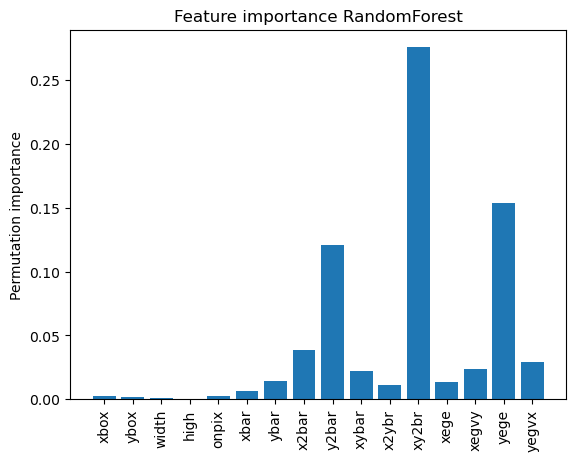

In [167]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=30, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    baseline = metric(y, model.predict(X))
    importances = []

    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, col])
            score = metric(y, model.predict(X_permuted))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)

importances = permutation_importance(rf_best, X_test, y_test, n_repeats=30, seed=RANDOM_SEED)

import matplotlib.pyplot as plt

plt.bar(range(len(feature_names)), importances)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.ylabel("Permutation importance")
plt.title("Feature importance RandomForest")
plt.show()
